In [1]:
import torch
import gym
import numpy as np

from matplotlib import pyplot as plt

In [2]:
env = gym.make('CartPole-v1')

/Users/lulu/Worskpace/rl-journey/.venv/lib/python3.10/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/lulu/Worskpace/rl-journey/.venv/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [126]:
class reinforce(torch.nn.Module):

    def __init__(self, policy: torch.nn.Module) -> None:
        super().__init__()
        self.policy = policy
    
    def forward(self, state):
        return self.policy(state)

class ActionReplayBuffer(torch.nn.Module):

    def __init__(self, gamma: float) -> None:
        super().__init__()
        self.gamma = gamma

        self.state_buffer = []
        self.action_buffer = []
        self.reward_buffer = []

    def __len__(self):
        return len(self.state_buffer)
    
    def push(self, state, action, reward):
        self.state_buffer.append(state)
        self.action_buffer.append(action)
        self.reward_buffer.append(reward)
    
    def sample(self):
        self.reward_buffer.reverse()

        for i in range(len(self.reward_buffer) - 1):
            self.reward_buffer[i + 1] = self.reward_buffer[i + 1] + ((self.gamma) * self.reward_buffer[i])

        self.reward_buffer.reverse()

        state_tensor = torch.tensor(self.state_buffer)
        action_tensor = torch.tensor(self.action_buffer)
        reward_tensor = torch.FloatTensor(self.reward_buffer)

        return state_tensor, action_tensor, reward_tensor

    def empty(self):
        self.state_buffer = []
        self.action_buffer = []
        self.reward_buffer = []

def action_multinomial(action_probabilities):
    output = torch.multinomial(action_probabilities, 1)
    return output.item()

def reinforce_loss(prob_batch, expected_returns_batch):
    return -torch.sum(torch.log(prob_batch)*expected_returns_batch) 


In [145]:
obs_size = env.observation_space.shape[0] 
n_actions = env.action_space.n  

HIDDEN_SIZE = 96

model = torch.nn.Sequential(
             torch.nn.Linear(obs_size, HIDDEN_SIZE),
             torch.nn.ReLU(),
             torch.nn.Linear(HIDDEN_SIZE, n_actions),
             torch.nn.Softmax(dim=0)
     )

In [146]:
learning_rate = 0.003

MAX_EPISODE_STEPS = 500
MAX_EPISODES = 1000

gamma = 0.99

In [147]:
agent = reinforce(model)
replay_buffer = ActionReplayBuffer(gamma)

optimizer = torch.optim.Adam(agent.parameters(), lr=learning_rate)

In [148]:
for trajectory in range(MAX_EPISODES + 1):
    curr_state = env.reset()
    done = False
    transitions = [] 
    
    for t in range(MAX_EPISODE_STEPS):
        torch_state = torch.from_numpy(curr_state).float()
        action_probs = agent(torch_state)

        action = action_multinomial(action_probs)

        prev_state = curr_state
        curr_state, _, done, info = env.step(action)

        transitions.append((prev_state, action, t+1))

        if done:
            break

    score.append(len(transitions))
    reward_batch = torch.Tensor([r for (s,a,r) in 
                   transitions]).flip(dims=(0,))

    batch_Gvals =[]
    for i in range(len(transitions)):
        new_Gval=0
        power=0
        for j in range(i,len(transitions)):
             new_Gval=new_Gval+((gamma**power)*reward_batch[j]).numpy()
             power+=1
        batch_Gvals.append(new_Gval)

    expected_returns_batch=torch.FloatTensor(batch_Gvals)
    expected_returns_batch /= expected_returns_batch.max()

    state_batch = torch.Tensor([s for (s,a,r) in transitions]) 
    action_batch = torch.Tensor([a for (s,a,r) in transitions])

    pred_batch = model(state_batch)
    prob_batch = pred_batch.gather(dim=1,index=action_batch
                 .long().view(-1,1)).squeeze() 
    
    loss = reinforce_loss(prob_batch, expected_returns_batch) 
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if trajectory % 50 == 0 and trajectory>0:
        print('Trajectory {}\tAverage Score: {:.2f}'.format(trajectory, np.mean(score[-50:-1])))

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [149]:
def torch_reinforce_train():
    score = []

    for trajectory in range(MAX_EPISODES + 1):
        curr_state = env.reset()
        done = False
    
        for t in range(MAX_EPISODE_STEPS):
            torch_state = torch.from_numpy(curr_state).float()
            action_probs = agent(torch_state)

            action = action_multinomial(action_probs)

            prev_state = curr_state
            curr_state, reward, done, info = env.step(action)

            replay_buffer.push(prev_state, action, reward)

            if done:
                break

        score.append(len(replay_buffer))

        state_batch, action_batch, reward_batch = replay_buffer.sample()
        replay_buffer.empty()

        reward_batch = reward_batch / reward_batch.max()

        pred_batch = model(state_batch)
        prob_batch = pred_batch.gather(dim=1,index=action_batch
                 .long().view(-1,1)).squeeze()
    
        loss = reinforce_loss(prob_batch, reward_batch) 
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if trajectory % 50 == 0 and trajectory>0:
            print('Trajectory {}\tAverage Score: {:.2f}'.format(trajectory, np.mean(score[-50:-1])))
    
    return score    

In [150]:
score = torch_reinforce_train()

Trajectory 50	Average Score: 33.69
Trajectory 100	Average Score: 57.27
Trajectory 150	Average Score: 73.98
Trajectory 200	Average Score: 184.16
Trajectory 250	Average Score: 249.39
Trajectory 300	Average Score: 309.76
Trajectory 350	Average Score: 262.47
Trajectory 400	Average Score: 327.90
Trajectory 450	Average Score: 437.14
Trajectory 500	Average Score: 335.12
Trajectory 550	Average Score: 349.53
Trajectory 600	Average Score: 480.84
Trajectory 650	Average Score: 477.24
Trajectory 700	Average Score: 381.55
Trajectory 750	Average Score: 456.92
Trajectory 800	Average Score: 473.29
Trajectory 850	Average Score: 479.41
Trajectory 900	Average Score: 471.82
Trajectory 950	Average Score: 430.49
Trajectory 1000	Average Score: 488.84


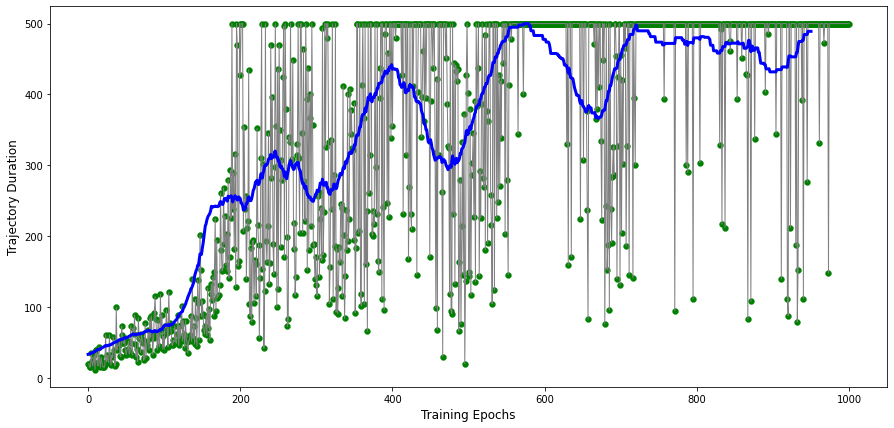

In [151]:
def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y

score = np.array(score)
avg_score = running_mean(score)
plt.figure(figsize=(15,7))
plt.ylabel("Trajectory Duration",fontsize=12)
plt.xlabel("Training Epochs",fontsize=12)
plt.plot(score, color='gray' , linewidth=1)
plt.plot(avg_score, color='blue', linewidth=3)
plt.scatter(np.arange(score.shape[0]),score, 
            color='green' , linewidth=0.3)

In [156]:
from IPython import display
from gym.wrappers import record_episode_statistics

def watch_agent():
  env = record_episode_statistics(gym.make('CartPole-v1'))
  state = env.reset()
  rewards = []
  img = plt.imshow(env.render(mode='rgb_array'))
  for t in range(2000):
    pred = model(torch.from_numpy(state).float())
    action = np.random.choice(np.array([0,1]), 
             p=pred.data.numpy())
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    rewards.append(reward)
    if done:
        print("Reward:", sum([r for r in rewards]))
        break 
  env.close()

In [157]:
watch_agent()

TypeError: 'module' object is not callable